<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# <center> Проект: Анализ вакансий из HeadHunter
   

In [179]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns

In [180]:
# вставьте сюда параметры подключения из юнита 1. Работа с базой данных из Python
import json

with open('data/connect.json', 'r') as f:
    config = json.load(f)

In [181]:
'''connection = psycopg2.connect(
    dbname=config['DBNAME'],
    user=config['USER'],
    host=config['HOST'],
    password=config['PASSWORD'],
    port=config['PORT']
)'''

#сделаем через SQLAlchemy, чтобы не было предупреждений
connection = f'''postgresql+psycopg2://{config['USER']}:{config['PASSWORD']}@{config['HOST']}:{config['PORT']}/{config['DBNAME']}'''


# Юнит 3. Предварительный анализ данных

1. Напишите запрос, который посчитает количество вакансий в нашей базе (вакансии находятся в таблице vacancies). 

In [182]:
# текст запроса
query_3_1 = f'''
    SELECT COUNT(*) AS num_vacancies
    FROM vacancies
'''

In [183]:
# результат запроса
num_vacancies = pd.read_sql_query(query_3_1, connection)
display(num_vacancies)

,num_vacancies
0,49197


2. Напишите запрос, который посчитает количество работодателей (таблица employers). 

In [184]:
# текст запроса
query_3_2 = f'''
SELECT COUNT(*) AS num_employers
FROM employers
'''

In [185]:
# результат запроса
num_employers = pd.read_sql_query(query_3_2, connection)
display(num_employers)

,num_employers
0,23501


3. Посчитате с помощью запроса количество регионов (таблица areas).

In [186]:
# текст запроса
query_3_3 = f'''
SELECT COUNT(*) AS num_areas
FROM areas
'''

In [187]:
# результат запроса
num_areas = pd.read_sql_query(query_3_3, connection)
display(num_areas)

,num_areas
0,1362


4. Посчитате с помощью запроса количество сфер деятельности в базе (таблица industries).

In [188]:
# текст запроса
query_3_4 = f'''
SELECT COUNT(*) AS num_industries
FROM industries
'''

In [189]:
# результат запроса
num_industries = pd.read_sql_query(query_3_4, connection)
display(num_industries)

,num_industries
0,294


***

### Выводы по предварительному анализу данных

Определено число записей во всех таблицах датасета. В среднем, на одну сферу деятельности приходится 160 вакансий, 17 работодателей на один регион. Но, естественно, это именно усредненные показатели, так как, например, в столичном регионе работодателей всегда намного больше, чем в провинции. В каждой сфере деятельности также могут быть разные потребности в работниках.

# Юнит 4. Детальный анализ вакансий

1. Напишите запрос, который позволит узнать, сколько (cnt) вакансий в каждом регионе (area).
Отсортируйте по количеству вакансий в порядке убывания.

In [190]:
# текст запроса
query_4_1 = f'''SELECT
    a.name AS area, -- выводим наименования регионов
    COUNT(v.name) AS cnt_vacancies_on_areas -- выводим общее количество вакансий
FROM
    vacancies AS v
-- объединяем таблицу вакансий с таблицей регионов
JOIN areas AS a ON v.area_id = a.id
GROUP BY area -- группируем по регионам
ORDER BY count(v.name) DESC -- сортируем количество вакансий по убыванию
LIMIT 5 -- ограничиваем вывод'''

,area,cnt_vacancies_on_areas
0,Москва,5333
1,Санкт-Петербург,2851
2,Минск,2112
3,Новосибирск,2006
4,Алматы,1892


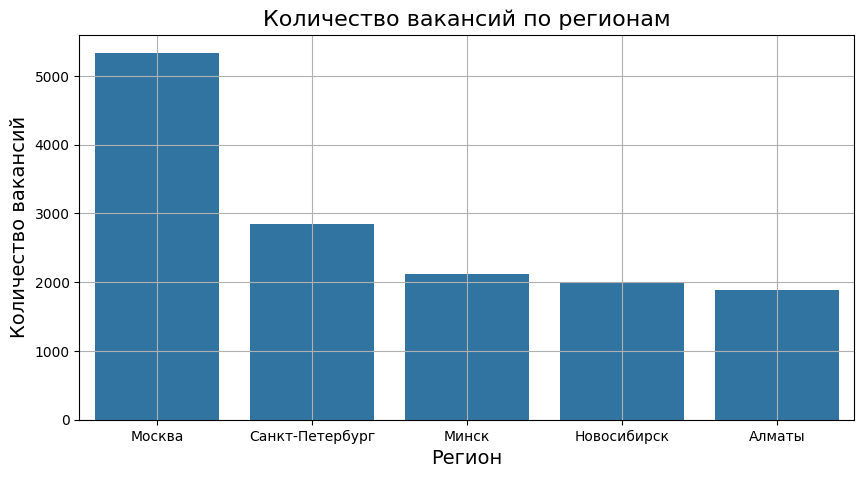

In [191]:
# результат запроса
cnt_vacancies_on_areas = pd.read_sql_query(query_4_1, connection)
display(cnt_vacancies_on_areas)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
barplot = sns.barplot(
    data=cnt_vacancies_on_areas,
    x='area',
    y='cnt_vacancies_on_areas',
    orient='v'
)
barplot.set_title('Количество вакансий по регионам', fontsize=16);
barplot.set_xlabel('Регион', fontsize=14);
barplot.set_ylabel('Количество вакансий', fontsize=14);
barplot.grid()

2. Напишите запрос, чтобы определить у какого количества вакансий заполнено хотя бы одно из двух полей с зарплатой.

In [192]:
# текст запроса
query_4_2 = f'''SELECT
    COUNT(name) AS cnt_vacancies_with_salary -- выводим количество вакансий
FROM vacancies
-- фильтруем вакансии, где указана мин или макс ЗП
WHERE salary_from IS NOT NULL OR salary_to IS NOT NULL'''

In [193]:
# результат запроса
cnt_vacancies_with_salary = pd.read_sql_query(query_4_2, connection)
display(cnt_vacancies_with_salary)

,cnt_vacancies_with_salary
0,24073


3. Найдите средние значения для нижней и верхней границы зарплатной вилки. Округлите значения до целого.

In [194]:
# текст запроса
query_4_3 =  f'''SELECT
    ROUND(AVG(salary_from), 0) AS salary_from_avg,
    ROUND(AVG(salary_to), 0) AS salary_to_avg
FROM vacancies'''

In [195]:
# результат запроса
avg_salary = pd.read_sql_query(query_4_3, connection)
display(avg_salary)

,salary_from_avg,salary_to_avg
0,71065.0,110537.0


4. Напишите запрос, который выведет количество вакансий для каждого сочетания типа рабочего графика (schedule) и типа трудоустройства (employment), используемого в вакансиях. Результат отсортируйте по убыванию количества.


In [196]:
# текст запроса
query_4_4 = f'''SELECT 
    COUNT(name) AS count_vacancies_on_type, -- количество вакансий
    schedule, -- тип рабочего графика
    employment -- тип трудоустройства
FROM vacancies
-- группируем по типу рабочего графика
-- и типу трудоустройства
GROUP BY schedule, employment
ORDER BY count_vacancies_on_type DESC -- сортируем вакансии по убыванию'''

,count_vacancies_on_type,schedule,employment
0,35367,Полный день,Полная занятость
1,7802,Удаленная работа,Полная занятость
2,1593,Гибкий график,Полная занятость
3,1312,Удаленная работа,Частичная занятость
4,940,Сменный график,Полная занятость


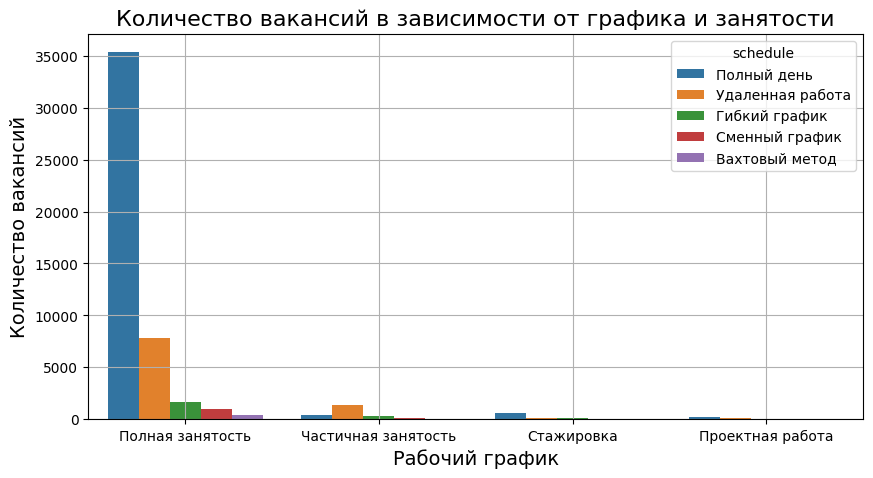

In [197]:
# результат запроса
count_vacancies_on_type = pd.read_sql_query(query_4_4, connection)
display(count_vacancies_on_type.head())

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
barplot = sns.barplot(
    data=count_vacancies_on_type,
    x='employment',
    hue='schedule',
    y='count_vacancies_on_type',
    orient='v'
)
barplot.set_title('Количество вакансий в зависимости от графика и занятости', fontsize=16);
barplot.set_xlabel('Рабочий график', fontsize=14);
barplot.set_ylabel('Количество вакансий', fontsize=14);
barplot.grid()

5. Напишите запрос, выводящий значения поля Требуемый опыт работы (experience) в порядке возрастания количества вакансий, в которых указан данный вариант опыта. 

In [198]:
# текст запроса
query_4_5 = f'''SELECT
    experience, -- требуемый опыт работы
    COUNT(name) AS vacancies -- количество вакансий
FROM vacancies
GROUP BY experience -- группируем по опыту работы
ORDER BY count(name) ASC -- сортируем вакансии по возрастанию''' 

,experience,vacancies
0,Более 6 лет,1337
1,Нет опыта,7197
2,От 3 до 6 лет,14511
3,От 1 года до 3 лет,26152


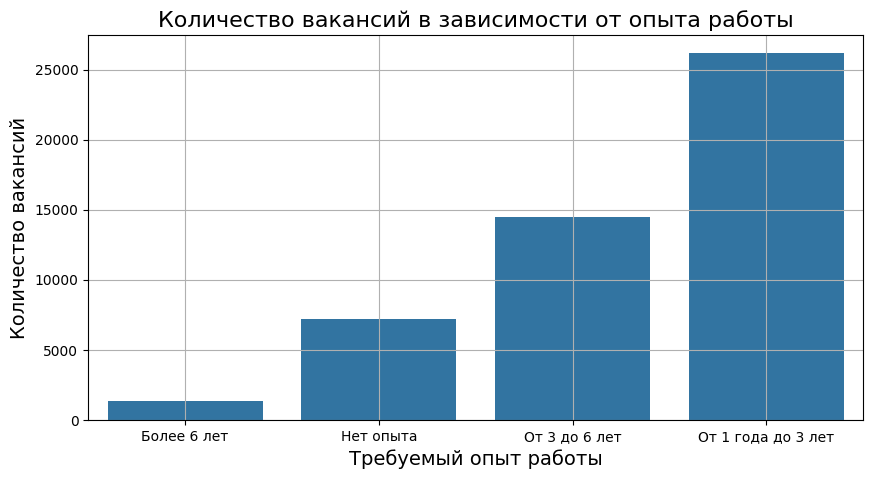

In [199]:
# результат запроса
experience = pd.read_sql_query(query_4_5, connection)
display(experience)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
barplot = sns.barplot(
    data=experience,
    x='experience',
    y='vacancies',
    orient='v'
)
barplot.set_title('Количество вакансий в зависимости от опыта работы', fontsize=16);
barplot.set_xlabel('Требуемый опыт работы', fontsize=14);
barplot.set_ylabel('Количество вакансий', fontsize=14);
barplot.grid()

***

### Выводы по детальному анализу вакансий

1. Как и ожидалось, наибольшее число вакансий относится к столичным регионам (больше всего в Москве, на втором месте - Санкт-Петербург).
2. Средние значения для нижней и верхней границы зарплатной вилки соответствуют средним показателям зарплаты по России на текущий момент времени.
3. Большинство работодателей ищут сотрудников на полный рабочий день - полную занятость. Удаленная работа нпбирает популярность, но таких вакансий все еще значительно меньше.
4. Требуемый опыт для большинства вакансий составляет от 1 года до 3 лет. Это говорит о том, что, во-первых, большинство вакансий относится к рядовым должностям, которые допускают больший уровень текучки кадров, чем высокие должности. Во-вторых, большинство работодателей все еще не готовы доверять сотрудникам без опыта.

# Юнит 5. Анализ работодателей

1. Напишите запрос, который позволит узнать, какие работодатели находятся на первом и пятом месте по количеству вакансий.

In [200]:
# текст запроса

In [201]:
# результат запроса

2. Напишите запрос, который для каждого региона выведет количество работодателей и вакансий в нём.
Среди регионов, в которых нет вакансий, найдите тот, в котором наибольшее количество работодателей.


In [202]:
# текст запроса

In [203]:
# результат запроса

3. Для каждого работодателя посчитайте количество регионов, в которых он публикует свои вакансии. Отсортируйте результат по убыванию количества.


In [204]:
# текст запроса

In [205]:
# результат запроса

4. Напишите запрос для подсчёта количества работодателей, у которых не указана сфера деятельности. 

In [206]:
# текст запроса

In [207]:
# результат запроса

5. Напишите запрос, чтобы узнать название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности. 

In [208]:
# текст запроса

In [209]:
# результат запроса

6. С помощью запроса выясните, у какого количества работодателей в качестве сферы деятельности указана Разработка программного обеспечения.


In [210]:
# текст запроса

In [211]:
# результат запроса

7. Для компании «Яндекс» выведите список регионов-миллионников, в которых представлены вакансии компании, вместе с количеством вакансий в этих регионах. Также добавьте строку Total с общим количеством вакансий компании. Результат отсортируйте по возрастанию количества.

Список городов-милионников надо взять [отсюда](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8). 

Если возникнут трудности с этим задание посмотрите материалы модуля  PYTHON-17. Как получать данные из веб-источников и API. 

In [212]:
# код для получения списка городов-милионников

In [213]:
# текст запроса

In [214]:
# результат запроса

***

In [215]:
# выводы по анализу работодателей

# Юнит 6. Предметный анализ

1. Сколько вакансий имеет отношение к данным?

Считаем, что вакансия имеет отношение к данным, если в её названии содержатся слова 'data' или 'данн'.

*Подсказка: Обратите внимание, что названия вакансий могут быть написаны в любом регистре.* 


In [216]:
# текст запроса

In [217]:
# результат запроса

2. Сколько есть подходящих вакансий для начинающего дата-сайентиста? 
Будем считать вакансиями для дата-сайентистов такие, в названии которых есть хотя бы одно из следующих сочетаний:
* 'data scientist'
* 'data science'
* 'исследователь данных'
* 'ML' (здесь не нужно брать вакансии по HTML)
* 'machine learning'
* 'машинн%обучен%'

** В следующих заданиях мы продолжим работать с вакансиями по этому условию.*

Считаем вакансиями для специалистов уровня Junior следующие:
* в названии есть слово 'junior' *или*
* требуемый опыт — Нет опыта *или*
* тип трудоустройства — Стажировка.
 

In [218]:
# текст запроса

In [219]:
# результат запроса

3. Сколько есть вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres?

** Критерии для отнесения вакансии к DS указаны в предыдущем задании.*

In [220]:
# текст запроса

In [221]:
# результат запроса

4. Проверьте, насколько популярен Python в требованиях работодателей к DS.Для этого вычислите количество вакансий, в которых в качестве ключевого навыка указан Python.

** Это можно сделать помощью запроса, аналогичного предыдущему.*

In [222]:
# текст запроса

In [223]:
# результат запроса

5. Сколько ключевых навыков в среднем указывают в вакансиях для DS?
Ответ округлите до двух знаков после точки-разделителя.

In [224]:
# текст запроса

In [225]:
# результат запроса

6. Напишите запрос, позволяющий вычислить, какую зарплату для DS в **среднем** указывают для каждого типа требуемого опыта (уникальное значение из поля *experience*). 

При решении задачи примите во внимание следующее:
1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.
3. Если в расчётах участвует null, в результате он тоже даст null (посмотрите, что возвращает запрос select 1 + null). Чтобы избежать этой ситуацию, мы воспользуемся функцией [coalesce](https://postgrespro.ru/docs/postgresql/9.5/functions-conditional#functions-coalesce-nvl-ifnull), которая заменит null на значение, которое мы передадим. Например, посмотрите, что возвращает запрос `select 1 + coalesce(null, 0)`

Выясните, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлите до целого числа. 

In [226]:
# текст запроса

In [227]:
# результат запроса

***

In [228]:
# выводы по предметному анализу

# Общий вывод по проекту

In [229]:
# подведем итог исследования, обобщите выводы
# здесь можно (это будет плюсом) провести дополнительные исследования данных, сделать прогнозы, продумать варианты продолжения исследования